### Litho 1.0 global sampling

Here we show how to extract information on depths of particular interfaces in the model at any point and the mechanism by which this is
implemented in the wrapper.

We also demonstrate the mechanism to query a depth profile at any lon/lat location and therefore how to construct a depth profile along
a great circle.



In [1]:
import litho1pt0 as litho
from pprint import pprint as pprint
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pyproj

import stripy


In [5]:
pprint(" Layer keys")
pprint( litho.l1_layer_decode.items() )
pprint(" Value keys")
pprint( litho.l1_data_decode.items() )

' Layer keys'
[('ASTHENO-TOP', 0),
 ('LID-BOTTOM', 1),
 ('LID-TOP', 2),
 ('CRUST3-BOTTOM', 3),
 ('CRUST3-TOP', 4),
 ('CRUST2-BOTTOM', 5),
 ('CRUST2-TOP', 6),
 ('CRUST1-BOTTOM', 7),
 ('CRUST1-TOP', 8),
 ('SEDS3-BOTTOM', 9),
 ('SEDS3-TOP', 10),
 ('SEDS2-BOTTOM', 11),
 ('SEDS2-TOP', 12),
 ('SEDS1-BOTTOM', 13),
 ('SEDS1-TOP', 14),
 ('WATER-BOTTOM', 15),
 ('WATER-TOP', 16),
 ('ICE-BOTTOM', 17),
 ('ICE-TOP', 18)]
' Value keys'
[('DEPTH', 0),
 ('DENSITY', 1),
 ('VP', 2),
 ('VS', 3),
 ('QKAPPA', 4),
 ('QMU', 5),
 ('VP2', 6),
 ('VS2', 7),
 ('ETA', 8)]


In [16]:
lats = np.array([0,0,0,0])
lons = np.array([10,10,10,10])
depths = np.array([1, 20, 100, 1000 ])


C, Vp = litho.property_at_lat_lon_depth_points(lats, lons, depths, quantity_ID='VP')

print C
print Vp

[8 6 2 0]
[6454 6663 8127 7965]


In [8]:
## Checking the integrity 

nlayers = len(litho.l1_layer_decode)
layer_depths     = np.empty((nlayers, lats.shape[0]))
layer_properties = np.empty((nlayers, lats.shape[0]))


for i in range(0, nlayers, 1 ):   
    layer_depths[i], err =  litho._interpolator.interpolate(lons * np.pi / 180.0, lats * np.pi / 180.0, 
                                                  litho._litho_data[i,litho.l1_data_decode["DEPTH"]], order=1)
      
    layer_properties[i], err = litho._interpolator.interpolate( lons * np.pi / 180.0, lats * np.pi / 180.0,
                                          litho._litho_data[i,litho.l1_data_decode["DENSITY"]], order=1)

                    

In [9]:
## make a global raster of some quantity

lonv, latv = np.meshgrid(np.linspace(-180,180,360), np.linspace(-90,90,180), sparse=False, indexing='xy')

l1 = litho.layer_depth(latv, lonv, "LID-BOTTOM")
l2 = litho.layer_depth(latv, lonv, "LID-TOP")

lthickness = (l1 - l2)*0.001

l1 = litho.layer_depth(latv, lonv, "CRUST3-BOTTOM")
l2 = litho.layer_depth(latv, lonv, "CRUST1-TOP")

cthickness = (l1 - l2)*0.001

In [10]:
## We ought to be able to put this is litho module !
    
def great_circle_profile(startlonlat, endlonlat, depths, resolution, QID):
    """
        model: self
        ll0: (lon0, lat0)
        ll1: (lon1, lat1)
        depths (km)
        resolution: separation (km) of locations to sample along the profile
    """
    
    import stripy

    lons, lats = stripy.spherical.great_circle_points(np.radians(startlonlat), np.radians(endlonlat), 1000)
    
    ## Would be useful to have distance measure here to map resolutions ... 
    
    data = np.empty( (lons.shape[0], depths.shape[0]))
    
    for s, ll in enumerate(lons):
        c, profile = litho.property_on_depth_profile(np.degrees(lats[s]), np.degrees(lons[s]), depths, QID)   
        data[s,:] = profile[:]
    
    
    return np.degrees(lons), np.degrees(lats), data
    
    
    

In [11]:
startlonlat = [ 90.0, 0.0]
endlonlat   = [ 90.0, 40.0]
midlonlat   = [ 90.0, 20.0]

lonr, latr = stripy.spherical.great_circle_points(np.radians(startlonlat), np.radians(endlonlat), 10)
lons = np.degrees(lonr)
lats = np.degrees(latr)


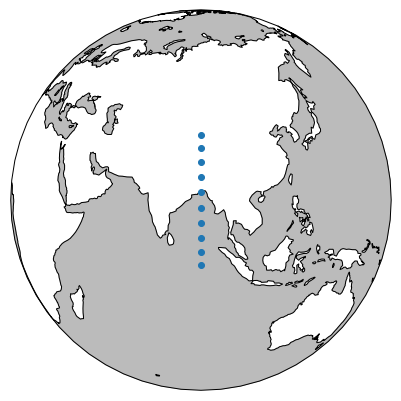

In [12]:
fig = plt.figure(figsize=(7, 7), facecolor="none")

ax  = plt.subplot(111, projection=ccrs.Orthographic(central_latitude=midlonlat[1], central_longitude=midlonlat[0]))
ax.set_global()

ax.add_feature(cartopy.feature.OCEAN, alpha=1.0, facecolor="#BBBBBB", zorder=0)
ax.scatter(lons, lats, transform=ccrs.Geodetic(), zorder=100)

ax.coastlines()


In [13]:
depths = np.linspace(-10.0, 250, 100)

lons, lats, d = great_circle_profile(startlonlat, endlonlat, depths, 2.5, "DENSITY")


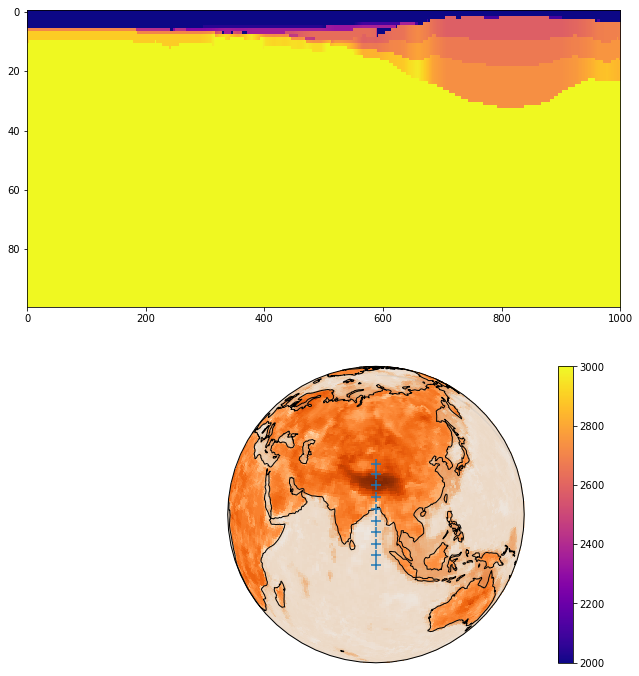

In [15]:

# Compute some properties about the profile line itself

drange = depths[-1] - depths[0]

#
# Cross section
#

fig = plt.figure(figsize=(12, 12), facecolor="none")
ax  = plt.subplot(211)
ax2 = plt.subplot(212, projection=ccrs.Orthographic(central_latitude=midlonlat[1], 
                                                    central_longitude=midlonlat[0]))

image = d[:,:]
m1 = ax.imshow(image.T, origin="upper", cmap="plasma", aspect=5.0, vmin=2000, vmax=3000)

plt.colorbar(mappable=m1, )


#
# Map / cross section
#

ax2.set_global()
global_extent     = [-180.0, 180.0, -90.0, 90.0]
m = ax2.imshow(cthickness, origin='lower', transform=ccrs.PlateCarree(),
              extent=global_extent, zorder=0, cmap="Oranges")


ax2.add_feature(cartopy.feature.OCEAN, alpha=0.25, facecolor="#BBBBBB")
ax2.coastlines()

lonr, latr = stripy.spherical.great_circle_points(np.radians(startlonlat), np.radians(endlonlat), 10)
ptslo  = np.degrees(lonr)
ptsla  = np.degrees(latr)

ax2.scatter (ptslo, ptsla, marker="+", s=100, transform=ccrs.Geodetic(), zorder=101)
